In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer


# Download NLTK stopwords (if not already done)
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [2]:
########################################
# 1. Preprocessing Helper Function
########################################
def preprocess_text(text):
    # Convert to string, lower-case, and strip extra spaces
    text = str(text).lower().strip()
    # Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

In [3]:
    ############################################
    # 2. Traditional Similarity Methods Class
    ############################################
class TraditionalSimilarity:
        def jaccard_similarity(self, q1, q2):
            words1 = set(q1.split())
            words2 = set(q2.split())
            intersection = len(words1.intersection(words2))
            union = len(words1.union(words2))
            return intersection / union if union != 0 else 0

        def levenshtein_similarity(self, s1, s2):
            m, n = len(s1), len(s2)
            dp = np.zeros((m+1, n+1), dtype=int)
            for i in range(m+1):
                dp[i][0] = i
            for j in range(n+1):
                dp[0][j] = j
            for i in range(1, m+1):
                for j in range(1, n+1):
                    if s1[i-1] == s2[j-1]:
                        dp[i][j] = dp[i-1][j-1]
                    else:
                        dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
            max_len = max(m, n)
            return 1 - (dp[m][n] / max_len) if max_len != 0 else 0

In [4]:
############################################
# 3. AI-Enhanced Similarity Methods using SentenceTransformer
############################################
class AIEnhancedSimilarity:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
    
    def semantic_similarity(self, q1, q2):
        embeddings = self.model.encode([q1, q2])
        sim = np.dot(embeddings[0], embeddings[1]) / (np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))
        return sim

In [5]:
############################################
# 4. Data Loading and Preprocessing
############################################
# Set sample_size as desired (using 15 rows here for demonstration)
sample_size = 20000
df = pd.read_csv('train.csv', nrows=sample_size)
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# Initialize similarity metric classes
trad_sim = TraditionalSimilarity()
ai_sim = AIEnhancedSimilarity()

In [6]:
############################################
# 5. Compute Similarity Features for Each Question Pair
############################################
print("Calculating similarity features...")
df['jaccard_sim'] = df.apply(lambda row: trad_sim.jaccard_similarity(row['question1'], row['question2']), axis=1)
df['levenshtein_sim'] = df.apply(lambda row: trad_sim.levenshtein_similarity(row['question1'], row['question2']), axis=1)
df['semantic_sim'] = df.apply(lambda row: ai_sim.semantic_similarity(row['question1'], row['question2']), axis=1)

Calculating similarity features...


In [7]:
############################################
# 6. Prepare Features, Split Data, and Train Classifier
############################################
# Feature set using the three similarity measurements
features = ['jaccard_sim', 'levenshtein_sim', 'semantic_sim']
X = df[features]
y = df['is_duplicate']  # 'is_duplicate' should be 0 or 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2495
           1       0.65      0.66      0.66      1505

    accuracy                           0.74      4000
   macro avg       0.72      0.73      0.73      4000
weighted avg       0.74      0.74      0.74      4000


Confusion Matrix:
[[1965  530]
 [ 505 1000]]



Accuracies for individual similarity measures:
Jaccard Similarity: 0.6542
Levenshtein Similarity: 0.6701
Semantic Similarity: 0.5919
Combined Model: 0.7412


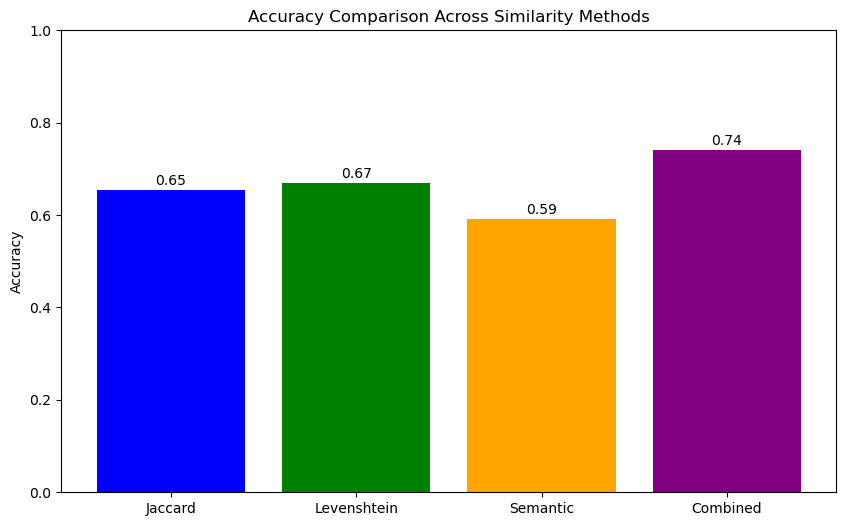

In [8]:
############################################
# 7. Print Accuracies for Individual Similarity Measures
############################################
# For similarity scores, we apply a threshold of 0.5 to get a binary prediction:
jaccard_pred = df['jaccard_sim'].apply(lambda x: 1 if x > 0.5 else 0)
levenshtein_pred = df['levenshtein_sim'].apply(lambda x: 1 if x > 0.5 else 0)
semantic_pred = df['semantic_sim'].apply(lambda x: 1 if x > 0.5 else 0)

jaccard_acc = accuracy_score(df['is_duplicate'], jaccard_pred)
levenshtein_acc = accuracy_score(df['is_duplicate'], levenshtein_pred)
semantic_acc = accuracy_score(df['is_duplicate'], semantic_pred)
combined_acc = accuracy_score(y_test, y_pred)

print("\nAccuracies for individual similarity measures:")
print(f"Jaccard Similarity: {jaccard_acc:.4f}")
print(f"Levenshtein Similarity: {levenshtein_acc:.4f}")
print(f"Semantic Similarity: {semantic_acc:.4f}")
print(f"Combined Model: {combined_acc:.4f}")

# Plot a bar graph comparing these accuracies
methods = ["Jaccard", "Levenshtein", "Semantic", "Combined"]
accuracies = [jaccard_acc, levenshtein_acc, semantic_acc, combined_acc]
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=["blue", "green", "orange", "purple"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Similarity Methods")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center")
plt.show()

In [ ]:
############################################
# 8. Sample Prediction Function for User Input
############################################
def predict_similarity(q1, q2):
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    feat = [
        trad_sim.jaccard_similarity(q1_processed, q2_processed),
        trad_sim.levenshtein_similarity(q1_processed, q2_processed),
        ai_sim.semantic_similarity(q1_processed, q2_processed)
    ]
    feat_scaled = scaler.transform([feat])
    pred = clf.predict(feat_scaled)[0]
    proba = clf.predict_proba(feat_scaled)[0][1]
    return pred, proba

In [10]:
# Example usage:
q1_sample = "How do I read and find my YouTube comments?"
q2_sample = "How can I see all my Youtube comments?"
prediction, probability = predict_similarity(q1_sample, q2_sample)
print(f"\nSample Prediction:")
print(f"Question 1: {q1_sample}")
print(f"Question 2: {q2_sample}")
print(f"Predicted as duplicate (1 = yes): {prediction} with probability {probability:.2f}")


Sample Prediction:
Question 1: How do I read and find my YouTube comments?
Question 2: How can I see all my Youtube comments?
Predicted as duplicate (1 = yes): 1 with probability 0.65


c:\Users\heman\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
from flask import Flask, request, render_template_string
import threading

# Assuming the necessary imports for the prediction function are here
# For example:
# from your_model import trad_sim, ai_sim, preprocess_text, scaler, clf

app = Flask(__name__)

# 8. Sample Prediction Function for User Input
def predict_similarity(q1, q2):
    # Preprocess the text (assumed to be your preprocessing function)
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    
    # Calculate traditional and AI-based similarity scores
    feat = [
        trad_sim.jaccard_similarity(q1_processed, q2_processed),
        trad_sim.levenshtein_similarity(q1_processed, q2_processed),
        ai_sim.semantic_similarity(q1_processed, q2_processed)
    ]
    
    # Scale features and predict
    feat_scaled = scaler.transform([feat])
    pred = clf.predict(feat_scaled)[0]
    proba = clf.predict_proba(feat_scaled)[0][1]
    
    return pred, proba

@app.route("/", methods=["GET", "POST"])
def index():
    result = ""
    if request.method == "POST":
        user_q1 = request.form.get("question1")
        user_q2 = request.form.get("question2")
        
        # Call the prediction function
        pred, proba = predict_similarity(user_q1, user_q2)
        
        # Determine the result message based on the prediction
        result = "✅ Matched (Duplicate)" if pred == 1 else "❌ Not Matched"
        result += f" with probability {proba:.2f}"
    
    # Reset the result if form was reset (GET method)
    if request.method == "GET":
        result = ""

    html = """
    <!doctype html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <title>Quora Question Pair Similarity</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
        <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
        <style>
            body {
                background-color: #f8f9fa;
                font-family: 'Arial', sans-serif;
            }
            .container {
                max-width: 600px;
                background: white;
                padding: 25px;
                margin-top: 50px;
                border-radius: 10px;
                box-shadow: 0px 0px 20px rgba(0,0,0,0.2);
                animation: fadeIn 1s ease-in-out;
            }
            @keyframes fadeIn {
                from { opacity: 0; transform: translateY(-20px); }
                to { opacity: 1; transform: translateY(0); }
            }
            .btn-custom {
                width: 100%;
                background-color: #007bff;
                color: white;
                border-radius: 5px;
                padding: 10px;
                transition: 0.3s;
            }
            .btn-custom:hover {
                background-color: #0056b3;
            }
            .btn-secondary {
                width: 100%;
                background-color: #6c757d;
                color: white;
                border-radius: 5px;
                padding: 10px;
                transition: 0.3s;
            }
            .btn-secondary:hover {
                background-color: #5a6268;
            }
            .form-control {
                padding: 10px;
                font-size: 16px;
                border-radius: 5px;
            }
            .result {
                text-align: center;
                font-size: 20px;
                margin-top: 20px;
                padding: 10px;
                border-radius: 8px;
                background: #d4edda;
                color: #155724;
                border: 1px solid #c3e6cb;
                animation: slideIn 0.5s ease-in-out;
            }
            @keyframes slideIn {
                from { opacity: 0; transform: scale(0.9); }
                to { opacity: 1; transform: scale(1); }
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h3 class="text-center text-primary">
                AI-Assisted Quora Question Pair Similarity Evaluation
            </h3>
            <p class="text-center text-muted">
                Using <strong>ALL-MINILM-L6-V2</strong> Model
            </p>
            <form method="post">
                <div class="mb-3">
                    <label for="question1" class="form-label">Question 1:</label>
                    <input type="text" class="form-control" id="question1" name="question1" required>
                </div>
                <div class="mb-3">
                    <label for="question2" class="form-label">Question 2:</label>
                    <input type="text" class="form-control" id="question2" name="question2" required>
                </div>
                <button type="submit" class="btn btn-custom">Predict Duplicate</button>
                <button type="reset" class="btn btn-secondary" onclick="resetForm()">Reset</button>
            </form>
            
            {% if result %}
                <div class="result mt-3">
                    Result: {{ result | safe }}
                </div>
            {% endif %}
        </div>
        <script>
            function resetForm() {
                document.getElementById("question1").value = '';
                document.getElementById("question2").value = '';
                document.querySelector('.result').style.display = 'none';  // Hide result div
            }
        </script>
    </body>
    </html>
    """
    return render_template_string(html, result=result)

# Function to run Flask app in a thread
def run_flask():
    app.run(host="127.0.0.60", port=5000, debug=False, use_reloader=False)

# Run Flask app in a separate thread
thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.60:5000
Press CTRL+C to quit


In [ ]:
# import requests
# import os

# # Check if the endpoint already exists before defining it
# if not any(rule.rule == '/shutdown' for rule in app.url_map.iter_rules()):
#     @app.route('/shutdown', methods=['POST'])
#     def shutdown():
#         os._exit(0)  # Forcefully stops the Flask app
#         return "Server shutting down..."

# def stop_flask():
#     try:
#         requests.post('http://127.0.0.60:5000/shutdown')
#     except requests.exceptions.RequestException:
#         print("Flask server stopped.")

# stop_flask()

Flask server stopped.


In [ ]:
# stop_flask

<function __main__.stop_flask()>